## Import des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as sm
from sklearn.cluster import KMeans
from sklearn import datasets

## Import du df de test

In [2]:
# Récupération du df de test
df_test = pd.read_csv(r"C:\Users\franc\OneDrive\Documents\OpenClassrooms\Projet 10\dataset_billets_production.csv")

# Suppression de la colonne id et diagonale
df_test = df_test.set_index("id")

# On renomme les colonnes en français
df_test.rename(columns={'length': 'longueur', 'height_left': 'hauteur_gauche', 'height_right': 'hauteur_droite', 
                          'is_genuine': 'authenticité', 'margin_up': 'marge_superieure',
                          'margin_low': 'marge_inferieure', 'diagonal':'diagonale'}, inplace=True)

# Réorganisation des colonnes
df_test = df_test[['diagonale', 'hauteur_gauche','hauteur_droite','marge_superieure','longueur','marge_inferieure']]
df_test

,diagonale,hauteur_gauche,hauteur_droite,marge_superieure,longueur,marge_inferieure
id,,,,,,
A_1,171.76,104.01,103.54,3.30,111.42,5.21
A_2,171.87,104.17,104.13,3.31,112.09,6.00
A_3,172.00,104.58,104.29,3.39,111.57,4.99
A_4,172.49,104.55,104.34,3.03,113.20,4.44
A_5,171.65,103.63,103.56,3.16,113.33,3.77


## Import du df_final

In [3]:
# Récupération du df complet issu d'une régression linéaire
df_final = pd.read_csv(r"C:\Users\franc\OneDrive\Documents\OpenClassrooms\Projet 10\df_billet_complet.csv")

# Suppression de la colonne Unnamed: 0
df_final = df_final.drop(['Unnamed: 0'], axis=1)
df_final.head()

,authenticité,diagonale,hauteur_gauche,hauteur_droite,marge_superieure,longueur,marge_inferieure
0,True,171.81,104.86,104.95,2.89,112.83,4.52
1,True,171.46,103.36,103.66,2.99,113.09,3.77
2,True,172.69,104.48,103.50,2.94,113.16,4.40
3,True,171.36,103.91,103.94,3.01,113.51,3.62
4,True,171.73,104.28,103.46,3.48,112.54,4.04


In [4]:
# Suppression de la colonne Authenticite
df_final_num = df_final.drop(['authenticité'], axis=1)

## Kmeans
### Détermination du nombre optimal de clusters

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


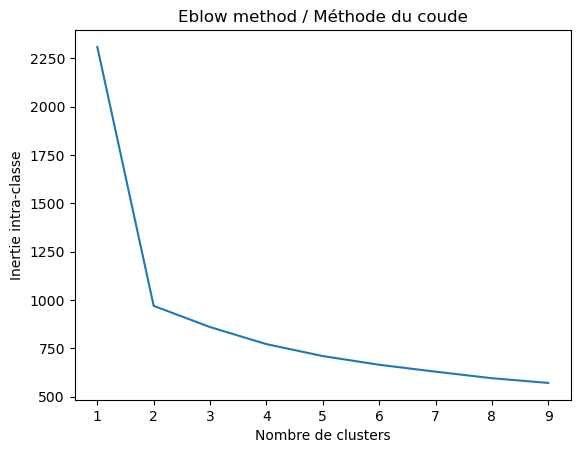

In [5]:
tab=[]
for i in range(1,10):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(df_final_num)
    tab.append(kmeans.inertia_)
plt.plot(range(1,10),tab)
plt.title("Eblow method / Méthode du coude")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie intra-classe")
plt.show()

On constate ici que l'inertie nous suggère 2 clusters, ce qui va nous permettre de cibler les 2 catégories cibles (Vrais / Faux billets).

## Réalisation des Kmeans à 2 clusters :

In [6]:
# Création du modèle
kmeans = KMeans(n_clusters=2)

# Entrainement du modèle
kmeans.fit(df_final_num)

KMeans(n_clusters=2)

In [7]:
# Récupération de la prédiction des Kmeans
clusters = kmeans.labels_

In [8]:
# Ajout des clusters de chaque billets sur le df
df_Kmeans = df_final.copy()
df_Kmeans['Clusters'] = clusters
df_Kmeans.head()

,authenticité,diagonale,hauteur_gauche,hauteur_droite,marge_superieure,longueur,marge_inferieure,Clusters
0,True,171.81,104.86,104.95,2.89,112.83,4.52,1
1,True,171.46,103.36,103.66,2.99,113.09,3.77,1
2,True,172.69,104.48,103.50,2.94,113.16,4.40,1
3,True,171.36,103.91,103.94,3.01,113.51,3.62,1
4,True,171.73,104.28,103.46,3.48,112.54,4.04,1


## Matrice de confusion

In [9]:
# Création de la matrice de confusion

matrice_confusion_km = pd.crosstab(df_final['authenticité'], clusters)
matrice_confusion_km.columns= ['Classe_0','Classe_1']
matrice_confusion_km.index = ['Faux','Vrai']
matrice_confusion_km

,Classe_0,Classe_1
Faux,481,19
Vrai,2,998


In [10]:
# Changement automatique des noms des clusters : 

# On regarde le pourcentage de vrais / faux billets par classe --> Ce qui déterminera la véracité de la classe.

if matrice_confusion_km.Classe_0[1] > matrice_confusion_km.Classe_0[0]:
    matrice_confusion_ok = matrice_confusion_km.rename(columns={'Classe_0': 'Prédit Vrai', 'Classe_1': 'Predit Faux'})
else :
    matrice_confusion_ok = matrice_confusion_km.rename(columns={'Classe_1': 'Prédit Vrai', 'Classe_0': 'Predit Faux'})

matrice_confusion_ok

,Predit Faux,Prédit Vrai
Faux,481,19
Vrai,2,998


In [11]:
print("Pour info dans notre jeu de données nous avons :")
print("Nombre de billet vrais :", df_final.loc[df_final["authenticité"] == 1,:].shape[0])
print("Nombre de billet faux :", df_final.loc[df_final["authenticité"] == 0,:].shape[0])

Pour info dans notre jeu de données nous avons :
Nombre de billet vrais : 1000
Nombre de billet faux : 500


In [12]:
# On peut ainsi calculer un indice de précision du modèle sur les données d'entrainement:
from sklearn import metrics

preci_km = metrics.adjusted_rand_score(clusters, df_Kmeans["authenticité"])
print ("Le modèle utilisant les Kmeans a donc une précision de :", "{:.2f}".format(100*preci_km) ,"%") 

Le modèle utilisant les Kmeans a donc une précision de : 94.40 %


In [13]:
centroids = kmeans.cluster_centers_

#description des centroides : 
df_Kmeans.groupby("Clusters").mean()

,authenticité,diagonale,hauteur_gauche,hauteur_droite,marge_superieure,longueur,marge_inferieure
Clusters,,,,,,,
0,0.004141,171.898634,104.193126,104.145031,3.347909,111.590269,5.241263
1,0.981318,171.986844,103.951839,103.813579,3.058181,113.195329,4.122629


## Algorithme

Pour prédire l'authenticité des billets on va : 
- Etape 1 : Prédire le cluster des billets en utilisant notre modèle de Kmeans
- Etape 2 : Interpréter la signification de chaque cluster (Vrai ou Faux)

Pour attribuer le cluster au billet on va utiliser la fonction km.predict. 
Cette fonction prédit le cluster le plus proche possible en utilisant la distance aux centroides.

Pour plus d'infos sur la fonction : 
> https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html pour plus d'infos
> ou encore : https://stackoverflow.com/questions/54511542/what-is-the-use-of-predict-method-in-kmeans-implementation-of-scikit-learn

Ainsi l'algorithme : 
- Utilise le clustering "kmeans" crée a partir des données disponibles et labélisées
- On applique ce modèle pour prédire l'authenticité avec kmeans.predict sur les data à tester
- On liste les billets prédits comme vrai/faux
- On rappelle la précision du modèle

In [14]:
#Algorithme : 
def test_Kmeans(data) :
    data_algo_km = kmeans.predict(data)
    data = data.assign(Prediction = data_algo_km)
    
    if matrice_confusion_km.Classe_0[1] > matrice_confusion_km.Classe_0[0]:
        v = data.query("Prediction == 0").index.tolist()
        f = data.query("Prediction == 1").index.tolist()
    
    else :
        v = data.query("Prediction == 1").index.tolist()
        f = data.query("Prediction == 0").index.tolist()
        
    print("les Billets suivants sont vraies :", v)
    print("Les Billets suivants sont des faux : ", f)
    print("La précision de la prédiction est de :", "{:.2f}".format(100* preci_km) ,"%")

In [15]:
test_Kmeans(df_test)

les Billets suivants sont vraies : ['A_4', 'A_5']
Les Billets suivants sont des faux :  ['A_1', 'A_2', 'A_3']
La précision de la prédiction est de : 94.40 %
